In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 데이터 로딩

In [3]:
trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset_raw = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [4]:
def preprocess_cifar(dataset):
    images = torch.tensor(np.transpose(np.array(dataset.data), (0,3,1,2)), dtype=torch.float32) / 255.0
    mean = images.mean([0,2,3], keepdim=True)
    std = images.std([0,2,3], keepdim=True)
    images = (images - mean) / std
    labels = torch.tensor(dataset.targets)
    return images, labels

In [5]:
train_images, train_labels = preprocess_cifar(trainset_raw)
test_images, test_labels = preprocess_cifar(testset_raw)

In [6]:
# train/val split
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size

In [7]:
train_images, val_images = torch.utils.data.random_split(train_images, [train_size, val_size])
train_labels, val_labels = torch.utils.data.random_split(train_labels, [train_size, val_size])

In [8]:
trainloader = torch.utils.data.DataLoader(list(zip(train_images, train_labels)), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(list(zip(val_images, val_labels)), batch_size=64, shuffle=False)

# 모델 생성

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [14]:
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습

In [15]:
# 로그 저장용 리스트
train_losses, train_accuracies, valid_losses, valid_accuracies = [], [], [], []

In [16]:
for epoch in range(30):                       # 총 40번 데이터셋을 반복
    model.train()                             # 학습 모드(드롭아웃/배치정규화 등 학습 동작 켜짐)
    running_loss = 0                          # 에폭 동안의 학습 손실 누적 변수
    train_correct, train_total = 0, 0         # (추가) 에폭 단위 Train Acc 계산용

    # ---- 미니배치 학습 루프 ----
    for inputs, labels in trainloader:        # DataLoader에서 (입력, 정답) 배치를 꺼냄
        inputs, labels = inputs.to(device), labels.to(device)  # 배치 텐서를 모델과 같은 장치로 이동
        optimizer.zero_grad()                 # 직전 step의 누적 gradient를 0으로 초기화
        outputs = model(inputs)               # 순전파: 모델이 logits(미규격화 점수) 출력
        loss = loss_fn(outputs, labels)       # 손실 계산(CrossEntropyLoss: softmax+NLL 통합)
        loss.backward()                       # 역전파: 각 파라미터의 gradient 계산
        optimizer.step()                      # 가중치 갱신(gradient를 이용해 한 스텝 업데이트)
        running_loss += loss.item()           # 현재 배치의 손실 값을 파이썬 float로 누적

        # (추가) 배치 예측으로 Train Acc 누적
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))  # 에폭 평균 학습 손실 기록 (배치 개수로 나눔)
    train_accuracies.append(100 * train_correct / train_total)     # 학습 정확도(%) 기록

    # ----- Validation -----
    model.eval()                              # 평가 모드(드롭아웃/BN 등 평가 동작)
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():                     # 평가 시에는 gradient 계산 비활성화(메모리/속도 이점)
        for inputs, labels in valloader:      # 검증 데이터 배치 반복
            inputs, labels = inputs.to(device), labels.to(device)  # 장치 정렬
            outputs = model(inputs)           # 순전파만 수행
            loss = loss_fn(outputs, labels)   # 검증 배치 손실
            val_loss += loss.item()           # 손실 누적
            _, predicted = torch.max(outputs, 1)     # 각 샘플의 최고 점수 클래스 인덱스
            total += labels.size(0)                  # 총 샘플 수 누적
            correct += (predicted == labels).sum().item()  # 맞춘 개수 누적

    valid_losses.append(val_loss / len(valloader))     # 에폭 평균 검증 손실 기록
    valid_accuracies.append(100 * correct / total)     # 검증 정확도(%) 기록

    # 진행 상황 출력(총 30에 맞추어 표기)
    print(f"Epoch {epoch+1}/30 : TRAIN[Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}%], VALID[Loss: {valid_losses[-1]:.4f}, Acc: {valid_accuracies[-1]:.2f}%]")

Epoch 1/50 : TRAIN[Loss: 2.3035, Acc: 9.71%], VALID[Loss: 2.3028, Acc: 9.60%]
Epoch 2/50 : TRAIN[Loss: 2.3029, Acc: 10.06%], VALID[Loss: 2.3029, Acc: 9.77%]
Epoch 3/50 : TRAIN[Loss: 2.3028, Acc: 9.76%], VALID[Loss: 2.3028, Acc: 9.76%]
Epoch 4/50 : TRAIN[Loss: 2.3029, Acc: 10.04%], VALID[Loss: 2.3028, Acc: 9.65%]
Epoch 5/50 : TRAIN[Loss: 2.3028, Acc: 9.90%], VALID[Loss: 2.3027, Acc: 9.61%]
Epoch 6/50 : TRAIN[Loss: 2.3027, Acc: 9.82%], VALID[Loss: 2.3033, Acc: 9.79%]
Epoch 7/50 : TRAIN[Loss: 2.3027, Acc: 9.94%], VALID[Loss: 2.3028, Acc: 10.19%]
Epoch 8/50 : TRAIN[Loss: 2.3027, Acc: 10.02%], VALID[Loss: 2.3029, Acc: 10.33%]
Epoch 9/50 : TRAIN[Loss: 2.3025, Acc: 10.22%], VALID[Loss: 2.3034, Acc: 9.98%]
Epoch 10/50 : TRAIN[Loss: 2.3025, Acc: 10.29%], VALID[Loss: 2.3033, Acc: 9.94%]
Epoch 11/50 : TRAIN[Loss: 2.3020, Acc: 10.46%], VALID[Loss: 2.3052, Acc: 9.72%]
Epoch 12/50 : TRAIN[Loss: 2.3001, Acc: 10.82%], VALID[Loss: 2.3041, Acc: 10.10%]
Epoch 13/50 : TRAIN[Loss: 2.2942, Acc: 11.85%], VAL

# 학습결과 확인

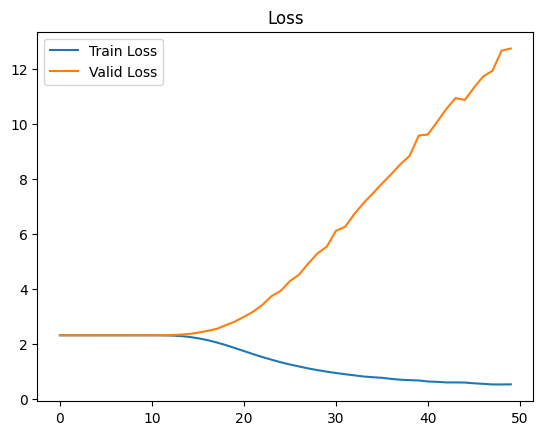

In [17]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Valid Loss")
plt.legend()
plt.title("Loss")
plt.show()

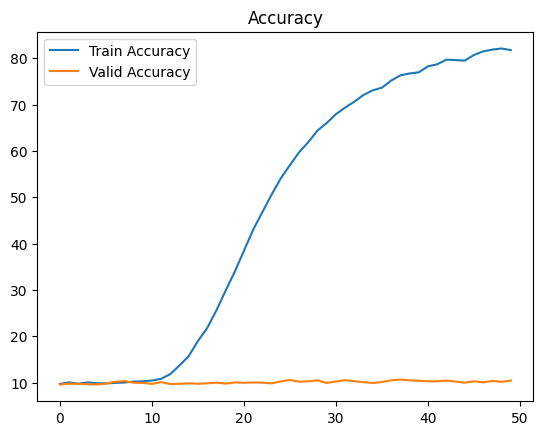

In [18]:
plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(valid_accuracies, label="Valid Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()